In [1]:
# Disable progress bars for small examples
from segysak.progress import Progress

Progress.set_defaults(disable=True)

# Extract data at the intersection of a horizon and 3D volume

In [2]:
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline

from segysak.segy import (
    get_segy_texthead,
    segy_header_scan,
    segy_header_scrape,
)

from os import path

## Load Small 3D Volume from Volve

In [3]:
volve_3d_path = path.join("data", "volve10r12-full-twt-sub3d.sgy")
print("3D", volve_3d_path, path.exists(volve_3d_path))

3D data/volve10r12-full-twt-sub3d.sgy True


In [4]:
get_segy_texthead(volve_3d_path)

Text HeaderC 1 SEGY OUTPUT FROM Petrel 2017.2 Saturday, June 06 2020 10:15:00              
C 2 Name: ST10010ZDC12-PZ-PSDM-KIRCH-FULL-T.MIG_FIN.POST_STACK.3D.JS-017534 ÝCro
C 3                                                                             
C 4 First inline: 10090  Last inline: 10150                                     
C 5 First xline:  2150   Last xline:  2351                                      
C 6 CRS: ED50-UTM31 ("MENTOR:ED50-UTM31:European 1950 Based UTM, Zone 31 North, 
C 7 X min: 433955.09 max: 436589.56 delta: 2634.47                              
C 8 Y min: 6477439.46 max: 6478790.23 delta: 1350.77                            
C 9 Time min: -3402.00 max: -2.00 delta: 3400.00                                
C10 Lat min: 58.25'52.8804"N max: 58.26'37.9493"N delta: 0.00'45.0689"          
C11 Long min: 1.52'7.1906"E max: 1.54'50.9616"E delta: 0.02'43.7710"            
C12 Trace min: -3400.00 max: -4.00 delta: 3396.00                               
C13 Seismic (template) min: -58.55 max: 54.55 delta: 113.10                     
C14 Amplitude (data) min: -58.55 max: 54.55 delta: 113.10                       
C15 Trace sample format: IEEE floating point                                    
C16 Coordinate scale factor: 100.00000                                          
C17                                                                             
C18 Binary header locations:                                                    
C19 Sample interval             : bytes 17-18                                   
C20 Number of samples per trace : bytes 21-22                                   
C21 Trace date format           : bytes 25-26                                   
C22                                                                             
C23 Trace header locations:                                                     
C24 Inline number               : bytes 5-8                                     
C25 Xline number                : bytes 21-24                                   
C26 Coordinate scale factor     : bytes 71-72                                   
C27 X coordinate                : bytes 73-76                                   
C28 Y coordinate                : bytes 77-80                                   
C29 Trace start time/depth      : bytes 109-110                                 
C30 Number of samples per trace : bytes 115-116                                 
C31 Sample interval             : bytes 117-118                                 
C32                                                                             
C33                                                                             
C34                                                                             
C35                                                                             
C36                                                                             
C37                                                                             
C38                                                                             
C39                                                                             
C40 END EBCDIC

In [5]:
volve_3d = xr.open_dataset(
    volve_3d_path,
    dim_byte_fields={"iline": 5, "xline": 21},
    extra_byte_fields={"cdp_x": 73, "cdp_y": 77},
)
volve_3d.segysak.scale_coords()
volve_3d.data

<xarray.DataArray 'data' (iline: 61, xline: 202, samples: 850)> Size: 42MB
[10473700 values with dtype=float32]
Coordinates:
  * iline    (iline) int16 122B 10090 10091 10092 10093 ... 10148 10149 10150
  * xline    (xline) int16 404B 2150 2151 2152 2153 2154 ... 2348 2349 2350 2351
  * samples  (samples) float32 3kB 4.0 8.0 12.0 ... 3.392e+03 3.396e+03 3.4e+03
Attributes:
    seisnc:   {"source_file": "data/volve10r12-full-twt-sub3d.sgy", "measurem...
    text:     C 1 SEGY OUTPUT FROM Petrel 2017.2 Saturday, June 06 2020 10:15...

## Load up horizon data

In [6]:
top_hugin_path = path.join("data", "hor_twt_hugin_fm_top.dat")
print("Top Hugin", top_hugin_path, path.exists(top_hugin_path))

Top Hugin data/hor_twt_hugin_fm_top.dat True


In [7]:
import pandas as pd

top_hugin_df = pd.read_csv(top_hugin_path, names=["cdp_x", "cdp_y", "samples"], sep=" ")
top_hugin_df.head()

,cdp_x,cdp_y,samples
0,432186.713151,6.477029e+06,2776.275147
1,432189.737524,6.477041e+06,2779.657715
2,432192.761898,6.477053e+06,2780.465088
3,432195.786271,6.477066e+06,2780.949951
4,432198.810645,6.477078e+06,2781.769775


Would be good to plot a seismic (iline,xline) section in Pyvista as well

In [8]:
# import pyvista as pv

# point_cloud = pv.PolyData(-1*top_hugin_df.to_numpy(), cmap='viridis')
# point_cloud.plot(eye_dome_lighting=True)

Alternativey we can use the points to output a `xarray.Dataset` which comes with coordinates for plotting already gridded up for Pyvista.

In [9]:
top_hugin_ds = volve_3d.seis.surface_from_points(
    top_hugin_df, "samples", right=("cdp_x", "cdp_y")
)
top_hugin_ds

<xarray.Dataset> Size: 99kB
Dimensions:  (iline: 61, xline: 202)
Coordinates:
  * iline    (iline) int16 122B 10090 10091 10092 10093 ... 10148 10149 10150
  * xline    (xline) int16 404B 2150 2151 2152 2153 2154 ... 2348 2349 2350 2351
    samples  (iline, xline) float64 99kB 2.741e+03 2.742e+03 ... 2.635e+03
Data variables:
    *empty*
Attributes:
    seisnc:   {"coord_scalar": -100.0, "coord_scaled": true}

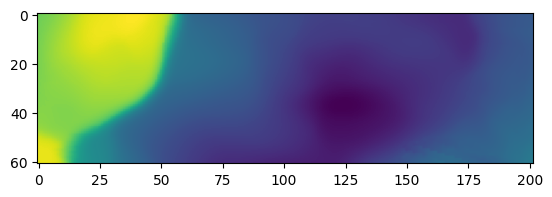

In [10]:
# the twt values from the points now in a form we can relate to the xarray cube.
plt.imshow(top_hugin_ds.samples)

In [11]:
# point_cloud = pv.StructuredGrid(
#     top_hugin_ds.cdp_x.values,
#     top_hugin_ds.cdp_y.values,top_hugin_ds.twt.values,
#     cmap='viridis')
# point_cloud.plot(eye_dome_lighting=True)

## Horizon Amplitude Extraction

Extracting horizon amplitudes requires us to interpolate the cube onto the 3D horizon.

In [12]:
top_hugin_amp = volve_3d.data.interp(
    {"iline": top_hugin_ds.iline, "xline": top_hugin_ds.xline, "samples": top_hugin_ds.samples}
)

<a list of 24 text.Text objects>

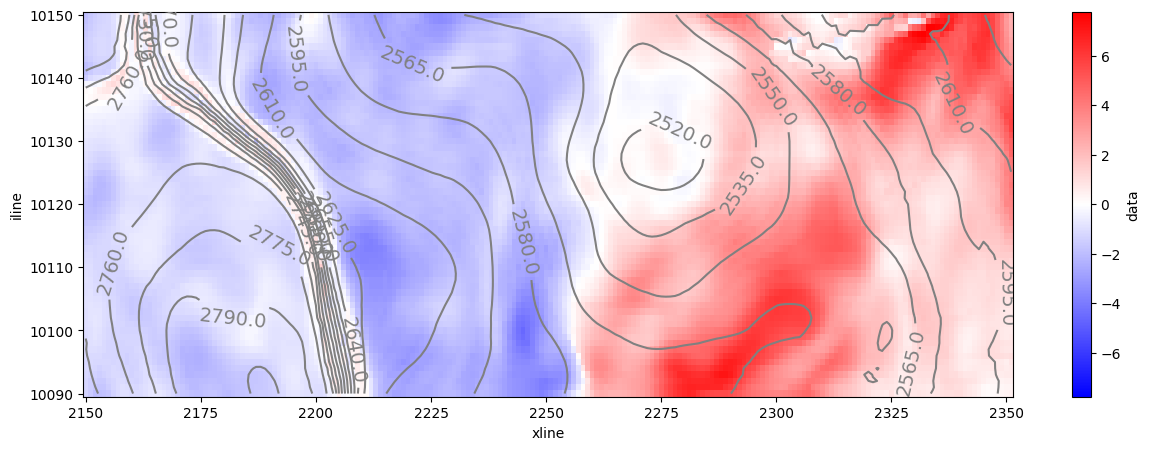

In [13]:
#
fig = plt.figure(figsize=(15, 5))
top_hugin_amp.plot(cmap="bwr")
cs = plt.contour(
    top_hugin_amp.xline, top_hugin_amp.iline, top_hugin_ds.samples, levels=20, colors="grey"
)
plt.clabel(cs, fontsize=14, fmt="%.1f")